# Exercise 6 - Decision Trees

In this exercise we will implement a decision tree classifier and evaluate its performance.

In the event of a persistent problem, do not hesitate to contact the course instructor under

- paul.kahlmeyer@uni-jena.de

### Submission
- Deadline of submission:
        24.05.23 23:59
- Submission on [moodle page](https://moodle.uni-jena.de/course/view.php?id=43681)


### Help
In case you cannot solve a task, you can use the saved values within the `help` directory:
- Load arrays with [Numpy](https://numpy.org/doc/stable/reference/generated/numpy.load.html)
```
np.load('help/array_name.npy')
```
- Load functions with [Dill](https://dill.readthedocs.io/en/latest/dill.html)
```
import dill
with open('help/some_func.pkl', 'rb') as f:
    func = dill.load(f)
```

to continue working on the other tasks.

In [138]:
import matplotlib.pyplot as plt

# Dataset

Here we will use a synthetic dataset for binary classification created with scikit learn (see [here](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html)).

### Task 1

Load and display the data located in `X.npy` and `y.npy`.

In [139]:
import matplotlib.pyplot as plt
# TODO: load and display data
import numpy as np

data_X = np.load("X.npy")
data_Y = np.load("y.npy")


np.column_stack((data_X, data_Y))

array([[ 1.33685399, -1.18802063,  1.        ],
       [-0.86860457,  0.96199178,  1.        ],
       [ 1.01438883,  1.11659789,  1.        ],
       ...,
       [-0.69498909,  0.82369382,  0.        ],
       [-1.43029196,  1.0429992 ,  0.        ],
       [-0.59294741,  0.967871  ,  0.        ]])

# Decision Trees

Decision trees are data structures, where at each level we make a decision about a feature and at the lowest level we have a decision for a class. For example, consider the following decision tree:
<div>
<img src="images/decision_tree.png" width="800"/>
</div>
You can think of a datapoint trickling down starting at the root and ending up in one of the leaf nodes that assign a class label.

That is, learning a decision tree involves learning which question to ask at which node.

## Learning

Usually we want to select questions in a way that "unmix" the labels of a dataset the best.

As an example, consider a dataset like this:

`X = [1, 2, 3, 4]`, `y = [0, 0, 1, 1]`

Here, we could ask the question: "$X\leq 1$?", which would split the dataset into 

`X1 = [1]`, `y1 = [0]` and 

`X2 = [2, 3, 4]`, `y2 = [0, 1, 1]`.

looking at the labels of the resulting datasets `y1` and `y2`, we can see that `y1` is nicely unmixed (contains only labels of one class). However `y2` is not unmixed.

A better question would be to ask: "$X\leq 2$?", in which case we would get

`X1 = [1, 2]`, `y1 = [0, 0]` and 

`X2 = [3, 4]`, `y2 = [1, 1]`.

Here both `y1` and `y2` are perfectly unmixed.

There are many ways to quantify the "unmixing" property of a dataset. For decision trees however a popular choice is the [**Gini-Impurity**](https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity). It measures the probability that we would missclasify a sample if we classified according to the distribution of labels.

Let $p_i$ be the relative frequency of class $i$ in the dataset with labels $y$, then the Gini-Impurity is defined as

\begin{align*}
I_G(y) = 1 - \sum_i p_i^2\,.
\end{align*}

In the following figure we can see the Gini-Impurity for binary classification problems depending on the relative frequency $p_0$ of class 0: 
<div>
<img src="images/gini.png" width="500"/>
</div>
If we have a perfectly unmixed dataset, the Gini-Impurity is 0. The maximum value is 0.5 if we have the same amount of both labels. Recall that for decision trees we want to split a dataset into subsets of low Gini-Impurity.

### Task 2

Implement the following function and calculate the Gini-Impurity for the labels of the dataset.

In [140]:
def gini_imp(y : np.ndarray) -> float:
    '''
    Calculates Gini-Impurity for binary labels.
    
    @Params:
        y... labels in {0, 1}
        
    @Returns: 
        Gini-Impurity
    '''
    # TODO: implement
    p0 = np.mean(y)
    p1 = 1-p0

    return 1-(p0**2 + p1**2)

# TODO: Gini-Impurity on dataset
'Gini-Impurity', gini_imp(data_Y)

('Gini-Impurity', 0.49992800000000004)

We want to use the Gini-Impurity to evaluate how good a splitting of a dataset is. For this we simply calculate a weighted sum of the impurities of the individual splits. Let $y_0, y_1$ be splits of a dataset $y$. Then we simply compute the score

\begin{align*}
S(y_0, y_1) = \cfrac{|y_0|}{|y_0| + |y_1|}I_G(y_0) + \cfrac{|y_1|}{|y_0| + |y_1|}I_G(y_1)\,.
\end{align*}

That is we weight each the individual impurities with the size of the splits.

### Task 3

Implement the following function and calculate the score if we would split the dataset according to the question "$x_0 \leq 0$?".

In [141]:
def gini_imp_split(y0 : np.ndarray, y1 : np.ndarray) -> float:
    '''
    Weighted Gini-Impurity for a split into two sets of labels (binary classification).
    
    @Params:
        y0... label set
        y1... label set
    
    @Returns:
        Impurity score (lower = better)
    '''
    # TODO: implement
    impurity0 = gini_imp(y0)
    impurity1 = gini_imp(y1)

    return len(y0)/len(data_Y)*impurity0 + len(y1)/len(data_Y)*impurity1

# TODO: calculate score for split x0 <= 0
mask = (data_X[:, 0] <= 0)
gini_imp_split(data_Y[mask], data_Y[~mask])

0.21925534616082165

Now the challenge is to find the index and the value that produces the lowest score ($\rightarrow$ best split).
For decision trees we do this in three steps:

1. Iterate trough all $x\in X$ and all dimensions $i$. Let $x_i = v$ be the value that we observe.
2. Score the split according to "$x_i \leq v$?".
3. Report dimension $i$ and value $v$ of best score

In practice we do not use the value $v$ but rather the average of $v$ and the first value for $x_i$ that is $> v$. 

As an example, if we identified $x_0 \leq 1.5$ as the best split, we will look for the lowest value of $x_0$ that is $>1.5$ and report the mean of those two values. Lets say this next greater value is $1.6$, then we will report index 0 and value $0.5(1.5 + 1.6) = 1.55$. This way we draw the decision boundary between the datapoints rather than on the datapoints.

### Task 4

Implement the following function that searches for the best split of a dataset.

Use this function to identify the best split of our dataset.

In [142]:
def best_split(X : np.ndarray, y : np.ndarray) -> tuple:
    '''
    Identifies the best split of a dataset according to Gini-Impurity.
    
    @Params:
        X... samples
        y... labels
        
    @Returns:
        triple (index, value, Gini-Score) of split
    '''
    # TODO: implement

    ret_w_imp = 1000 # just so that premature termination is visually clear.
    ret_i = -1
    ret_v = -1

    for x in X:
        for split_idx in range(len(x)):
            split_v = x[split_idx]

            mask = (X[:, split_idx] <= split_v)
            y1 = y[mask]
            y2 = y[~mask]

            if len(y1) > 0 and len(y2) > 0:
                w_imp = gini_imp_split(y1, y2)
                if w_imp < ret_w_imp:
                    ret_w_imp = w_imp
                    ret_v = split_v
                    ret_i = split_idx

    v_next = np.min(X[(X[:, ret_i] > ret_v), ret_i])
    return (ret_i, 0.5*(ret_v + v_next), ret_w_imp)

# TODO: find best split for dataset

best_split(data_X, data_Y)

(0, -0.15385073614765354, 0.19709883984704135)

With this functionality we have everything to recursively build up a decision tree.

Each node in the tree has the following attributes:

- `X`, `y`, `gi`: part of the dataset that is passed to the node
- `depth`, `max_depth`: depth of the node in the tree as well as the maximum depth of the tree

And can perform the following operations:

- `split`: if not already pure or at `max_depth`, finds the best split of its dataset and creates two child nodes (+1 depth)
- `predict` : given a dataset predicts labels accoding to its children (or according to its labels if we have no children)

### Task 5

Implement the following `Node` class which implements the functionality of a single node. 

Use the provided `DecisionTree` class to learn and print a decision tree on our dataset.

In [143]:
class Node():
        
    def __init__(self, X : np.ndarray, y : np.ndarray, depth : int, max_depth : int):
        '''
        Constructor for a node.
        
        @Params:
            X... samples
            y... labels
            depth... depth of this node in the tree
            max_depth... maximum depth of any node in the tree
        '''
        # TODO: implement
        self.X = X
        self.y = y
        self.depth = depth
        self.max_depth = max_depth
        self.left = None
        self.right = None

        self.split_idx = None
        self.split_value = None
        self.best_gi = None

        self.is_leaf = False
        pass
        
        
        
    def split(self):
        '''
        Creates child nodes if labels are not already pure.
        '''
        # TODO: implement
        _rh = np.sum(self.y)/len(self.y)

        if self.depth < self.max_depth and 0 < _rh < 1:
            self.split_idx, self.split_value, self.best_gi = best_split(self.X, self.y)
            mask = (self.X[:, self.split_idx] <= self.split_value)

            self.left = Node(self.X[mask], self.y[mask], self.depth + 1, self.max_depth)
            self.left.split()

            self.right = Node(self.X[~mask], self.y[~mask], self.depth + 1, self.max_depth)
            self.right.split()
        else:
            # this is the case when no more splitting can take place (the list has length 1)
            self.is_leaf = True
            # end the recursion
            return

        
    def predict(self, X : np.ndarray) -> np.ndarray:
        '''
        Predicts labels for samples.
        
        @Params:
            X... samples
            
        @Returns:
            predicted labels by this node
        '''
        # TODO: implement
        if self.is_leaf:
            return int(np.mean(self.y) > 0.5) * np.ones(len(X))
        else:
            prediction = np.ones(len(X))
            mask = (X[:, self.split_idx] <= self.split_value)
            prediction[mask] = self.left.predict(X[mask])
            prediction[~mask] = self.right.predict(X[~mask])

            return prediction
            
        
    def __repr__(self) -> str:
        '''
        String representation of the node.
        
        @Returns:
            a string that represents the subtree with this node as root.
            Something like 
            x0 < 1.5?
                str(child1)
            else
                str(child2)
            
        '''
        # TODO: implement
        if self.is_leaf:
            return str(np.mean(self.y))

        _tabs = '\t'*self.depth
        return f"x{self.split_idx} <= {self.split_value}?\n{_tabs}\t{str(self.left)}\n{_tabs}else:\n{_tabs}\t{str(self.right)}"


class DecisionTree():
    '''
    Provided. A wrapper class for the root of the decision tree.
    This will give you an idea of how the Node class is used.
    '''
    
    def __init__(self, max_depth : int = np.inf):
        '''
        Constructor of decision tree.
        
        @Params:
            max_depth... maximum depth of any node in the tree
        '''
        self.root = None
        self.max_depth = max_depth
        
    def fit(self, X : np.ndarray, y : np.ndarray):
        '''
        Learns the nodes of the decision tree.
        
        @Params:
            X... samples
            y... labels
        '''
        self.root = Node(X, y, 0, self.max_depth)
        self.root.split()
        
    def predict(self, X : np.ndarray) -> np.ndarray:
        '''
        Predicts labels for samples.
        
        @Params:
            X... samples
        '''
        return self.root.predict(X)
    
    def __repr__(self) -> str:
        '''
        String representation of the tree.
        '''
        return str(self.root)
    
# TODO: learn + print decision tree
dt = DecisionTree(max_depth=3)
dt.fit(data_X, data_Y)
print(dt)

x0 <= -0.15385073614765354?
	x1 <= 1.2240952599987902?
		x0 <= -0.33968405109517646?
			0.058333333333333334
		else:
			0.4666666666666667
	else:
		1.0
else:
	x0 <= 0.3295256957451717?
		x1 <= 0.4708509772502949?
			1.0
		else:
			0.5909090909090909
	else:
		x1 <= 0.6184130862987511?
			1.0
		else:
			0.9375


### Task 6

Calculate the accuracy of the decision tree on the dataset and visualize the decision boundary.

You can use `utils.plot_dec_boundary` for the visualization.

0.932


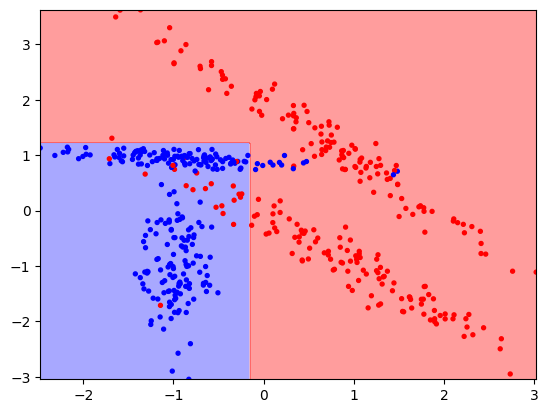

In [144]:
# TODO: accuracy and decision boundary
import utils

acc = np.mean(dt.predict(data_X) == data_Y)
print(acc)

utils.plot_dec_boundary(data_X, data_Y, dt)

### Task 7

Use the [scikit learn implementation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) to learn a decision tree with the same maximum depth as your tree from Task 5.

Compare the decision boundary, accuracy and the internal parameters to those of your own implementation.

In [145]:
# TODO: use scikit learn implementation
from sklearn.tree import DecisionTreeClassifier
dt2 = DecisionTreeClassifier(max_depth=2).fit(data_X, data_Y)

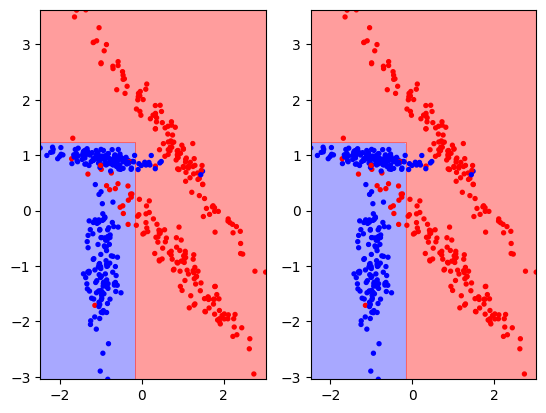

In [146]:
# TODO: compare decision boundary
fig, ax = plt.subplots(1, 2)
utils.plot_dec_boundary(data_X, data_Y, dt, ax[0])

utils.plot_dec_boundary(data_X, data_Y, dt2, ax[1])

In [147]:
# TODO: compare accuracy
np.mean(dt2.predict(data_X) == data_Y)

0.932

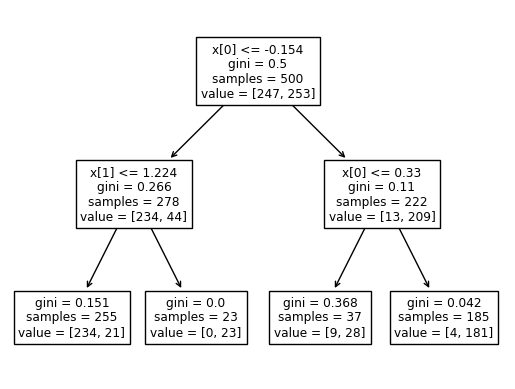

In [148]:
# TODO: compare parameters
from sklearn import tree
tree.plot_tree(dt2)
plt.show()

## Influence of Tree depth

Now we want to investigate the influence of the maximum tree depth on the classification accuracy.

### Task 8

Split the dataset into train- and testdata and plot the train- and test accuracy for an increasing maximum tree depth.

You can use the scikit learn implementation or your own.

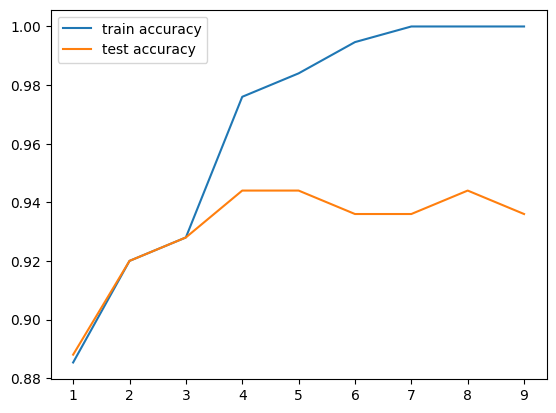

In [149]:
# TODO: plot train and test accuracy for increasing tree depth
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(data_X, data_Y)

depth = np.arange(1, 10)
train_accuracy = []
test_accuracy = []

for d in depth:
    _dt_classifier = DecisionTreeClassifier(max_depth=d).fit(X_train, Y_train)
    train_accuracy.append(
        np.mean(_dt_classifier.predict(X_train) == Y_train)
    )
    test_accuracy.append(
        np.mean(_dt_classifier.predict(X_test) == Y_test)
    )

plt.plot(depth, train_accuracy, label='train accuracy')
plt.plot(depth, test_accuracy, label='test accuracy')

plt.legend()
plt.show()

### Task 9

In your own words, describe the influence of the maximum tree depth.

The optimal tree depth is where test and train accuracy is high. As we know from previous exercises, if the train accuracy gets very high and the test accuracy gets lower: we have overfitting. The model is very good on the train data - but fails to perform well on different data.